# Import Required Libraries
Import the necessary libraries, including NumPy, Matplotlib, and CUDA related libraries.

In [83]:
import glob
import os
import re

import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# Initialize variables
Initialize the variables required for the program.

**Set the log folder path to the location where the log files are stored.**

In [84]:
logs_directory = "../output_cuda/mult_array_cuda/logs/"
output_filename = "mult_array_cuda"

log_files = glob.glob(os.path.join(logs_directory, "*.csv"))

# all_data = pd.DataFrame()
all_data = []

# CUDA Analysis
This part is for analyzing the log files and extracting the required information.

In [85]:
def convert_to_microseconds(value, unit):
    if unit == "ms":
        return value * 1e3
    elif unit == "s":
        return value * 1e6
    elif unit == "us":
        return value
    else:
        raise ValueError(f"Unknown time unit: {unit}")

## Read the log files
Read the log files and extract the required information.

🚧 Work in progress 🚧

In [86]:
log_file = log_files[3]


def read_log_file(log_file: str):
    # Get parameters from log filename
    numbers = re.findall(r"\d+", log_file)
    array_size, grid_size, block_size, exp_num = map(int, numbers)
    array_size = int(array_size)
    grid_size = int(grid_size)
    block_size = int(block_size)
    exp_num = int(exp_num)

    # Get headers and units from log file
    with open(log_file, "r") as f:
        lines = f.readlines()
        headers = lines[4].strip().replace('"', "").split(",")
        units = lines[5].strip().split(",")

    # Read log file
    data = pd.read_csv(
        log_file,
        skiprows=5,
    )
    # Name the columns and convert time to microseconds if necessary
    data.columns = [f"{header} ({unit})" for header, unit in zip(headers, units)]
    gpu_data = data[data["Type ()"] == "GPU activities"]
    if "ms" in units:
        # Convert 'Time' values to microseconds
        gpu_data.loc[:, "Time (ms)"] = gpu_data["Time (ms)"].apply(
            lambda x: convert_to_microseconds(x, "ms")
        )
        gpu_data = gpu_data.rename(columns={"Time (ms)": "Time (us)"})

    # print(gpu_data)
    return {
        "Array Size": array_size,
        "Grid Size": grid_size,
        "Block Size": block_size,
        "Experiment Number": exp_num,
        "GPU Sum": gpu_data[
            "Time (us)"
        ].sum(),  # Sum of all GPU times, in microseconds (us)
    }


read_log_file(log_file)

{'Array Size': 512,
 'Grid Size': 1024,
 'Block Size': 4,
 'Experiment Number': 3,
 'GPU Sum': 10.432}

In [87]:
for log_file in tqdm(log_files):
    all_data.append(read_log_file(log_file))

# print(all_data)

100%|██████████| 5280/5280 [00:16<00:00, 312.73it/s]


In [88]:
all_data = pd.DataFrame(all_data)

# Calculate mean of GPU Sum for each combination of parameters
mean_data = (
    all_data.groupby(["Array Size", "Grid Size", "Block Size"])["GPU Sum"]
    .mean()
    .reset_index()
)

# Visualize the Data
Plot the data using `matplotlib`.

There are different tests on how to visualize the data. Feel free to explore them.

## Testing 3D Graph plot
This is a test to plot a 3D graph using `matplotlib`.

Each point in the graph represents the array size, the number of threads, the number of blocks, and the execution time.

Plotting the results...


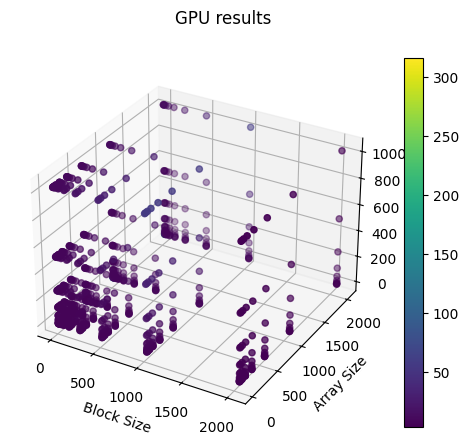

In [89]:
print("Plotting the results...")
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(
    mean_data["Block Size"],
    mean_data["Array Size"],
    mean_data["Grid Size"],
    c=mean_data["GPU Sum"],
)
plt.colorbar(sc)
ax.set_xlabel("Block Size")
ax.set_ylabel("Array Size")
ax.set_label("Grid Size")
fig.suptitle("GPU results")

plt.show()
fig.savefig(f"{output_filename}_3D_test.png")
# print(f"Plot saved to {output_png}")

## Testing 2D Graph plot

Here, we are trying a different approach to visualize the data.

The dataset is plotted in a 2D graph, where the x-axis represents the array size, and the y-axis represents the execution time.
The colors represent the grid size, which is the number of threads and blocks in the GPU.

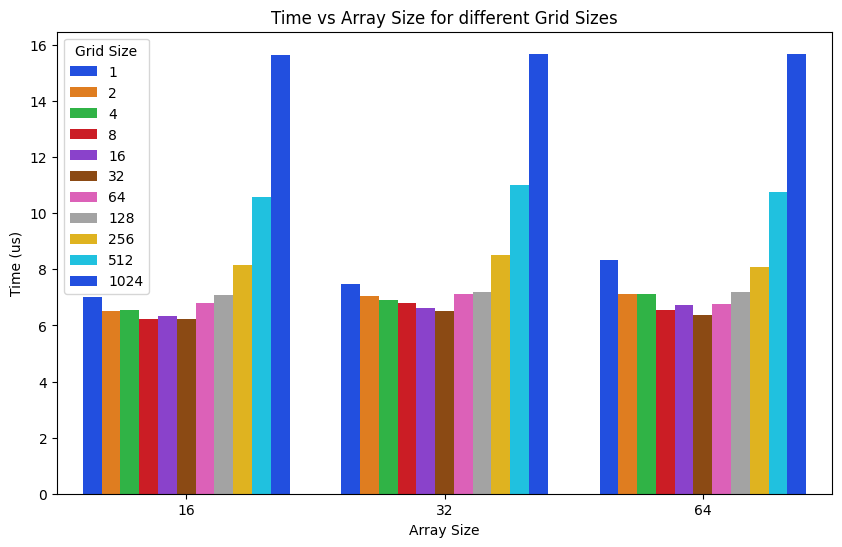

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

filtered_data = mean_data[mean_data["Array Size"] <= 64]

fig = plt.figure(figsize=(10, 6))
sns.barplot(
    x="Array Size",
    y="GPU Sum",
    hue="Grid Size",
    data=filtered_data,
    palette="bright",
    errorbar=None,
)

plt.title("Time vs Array Size for different Grid Sizes")
plt.xlabel("Array Size")
plt.ylabel("Time (us)")

plt.show()
fig.savefig(f"{output_filename}_barplot_test.png")

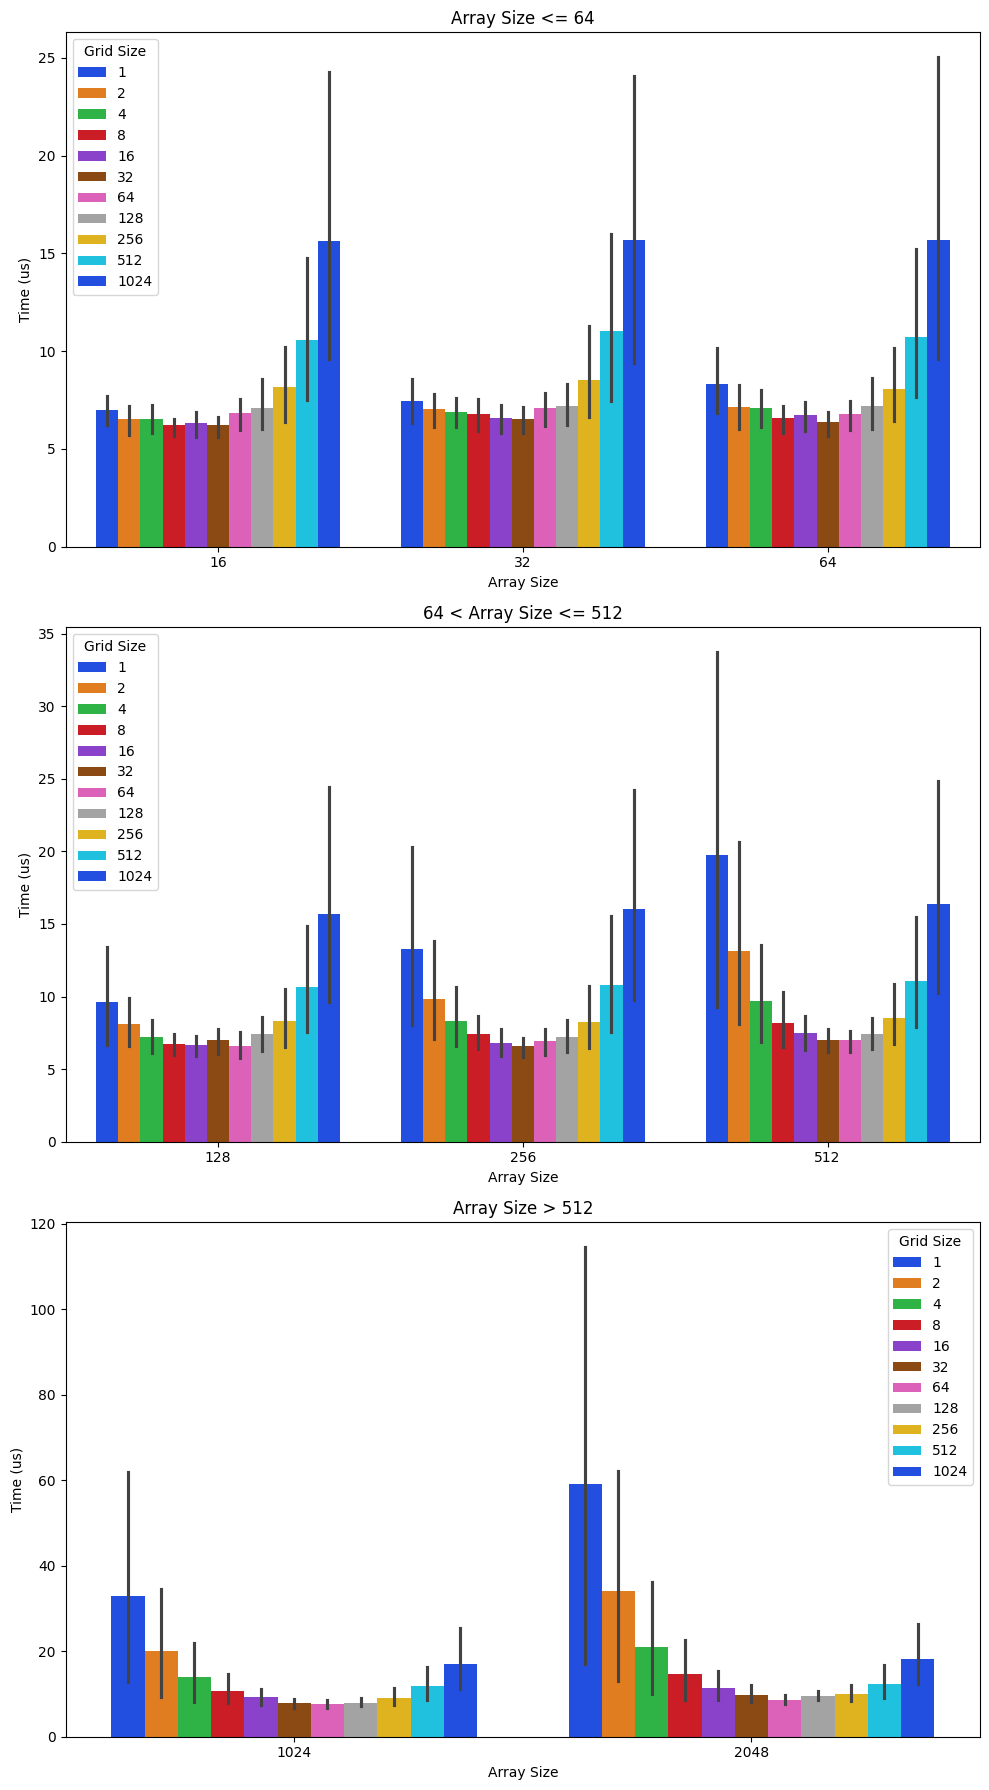

In [91]:
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

lower_bound = 64
medium_bound = 512
higher_bound = 2048

lower_data = mean_data[mean_data["Array Size"] <= lower_bound]
medium_data = mean_data[
    (mean_data["Array Size"] > lower_bound) & (mean_data["Array Size"] <= medium_bound)
]
higher_data = mean_data[mean_data["Array Size"] > medium_bound]

sns.barplot(
    x="Array Size",
    y="GPU Sum",
    hue="Grid Size",
    data=lower_data,
    palette="bright",
    ax=axs[0],
).set_ylabel("Time (us)")
sns.barplot(
    x="Array Size",
    y="GPU Sum",
    hue="Grid Size",
    data=medium_data,
    palette="bright",
    ax=axs[1],
).set_ylabel("Time (us)")
sns.barplot(
    x="Array Size",
    y="GPU Sum",
    hue="Grid Size",
    data=higher_data,
    palette="bright",
    ax=axs[2],
).set_ylabel("Time (us)")

# Set titles for each subplot
axs[0].set_title("Array Size <= " + str(lower_bound))
axs[1].set_title(str(lower_bound) + " < Array Size <= " + str(medium_bound))
axs[2].set_title("Array Size > " + str(medium_bound))

plt.tight_layout()
plt.show()
fig.savefig(f"{output_filename}_categorized_barplot.png")

## Full comparison

This plot is a complete comparison of the execution time for different array sizes, grid sizes, and block sizes.
It is a huge plot, but it gives a clear idea of the execution time for different configurations.
Moreover, it offers an overview of the performance of the CUDA kernel.

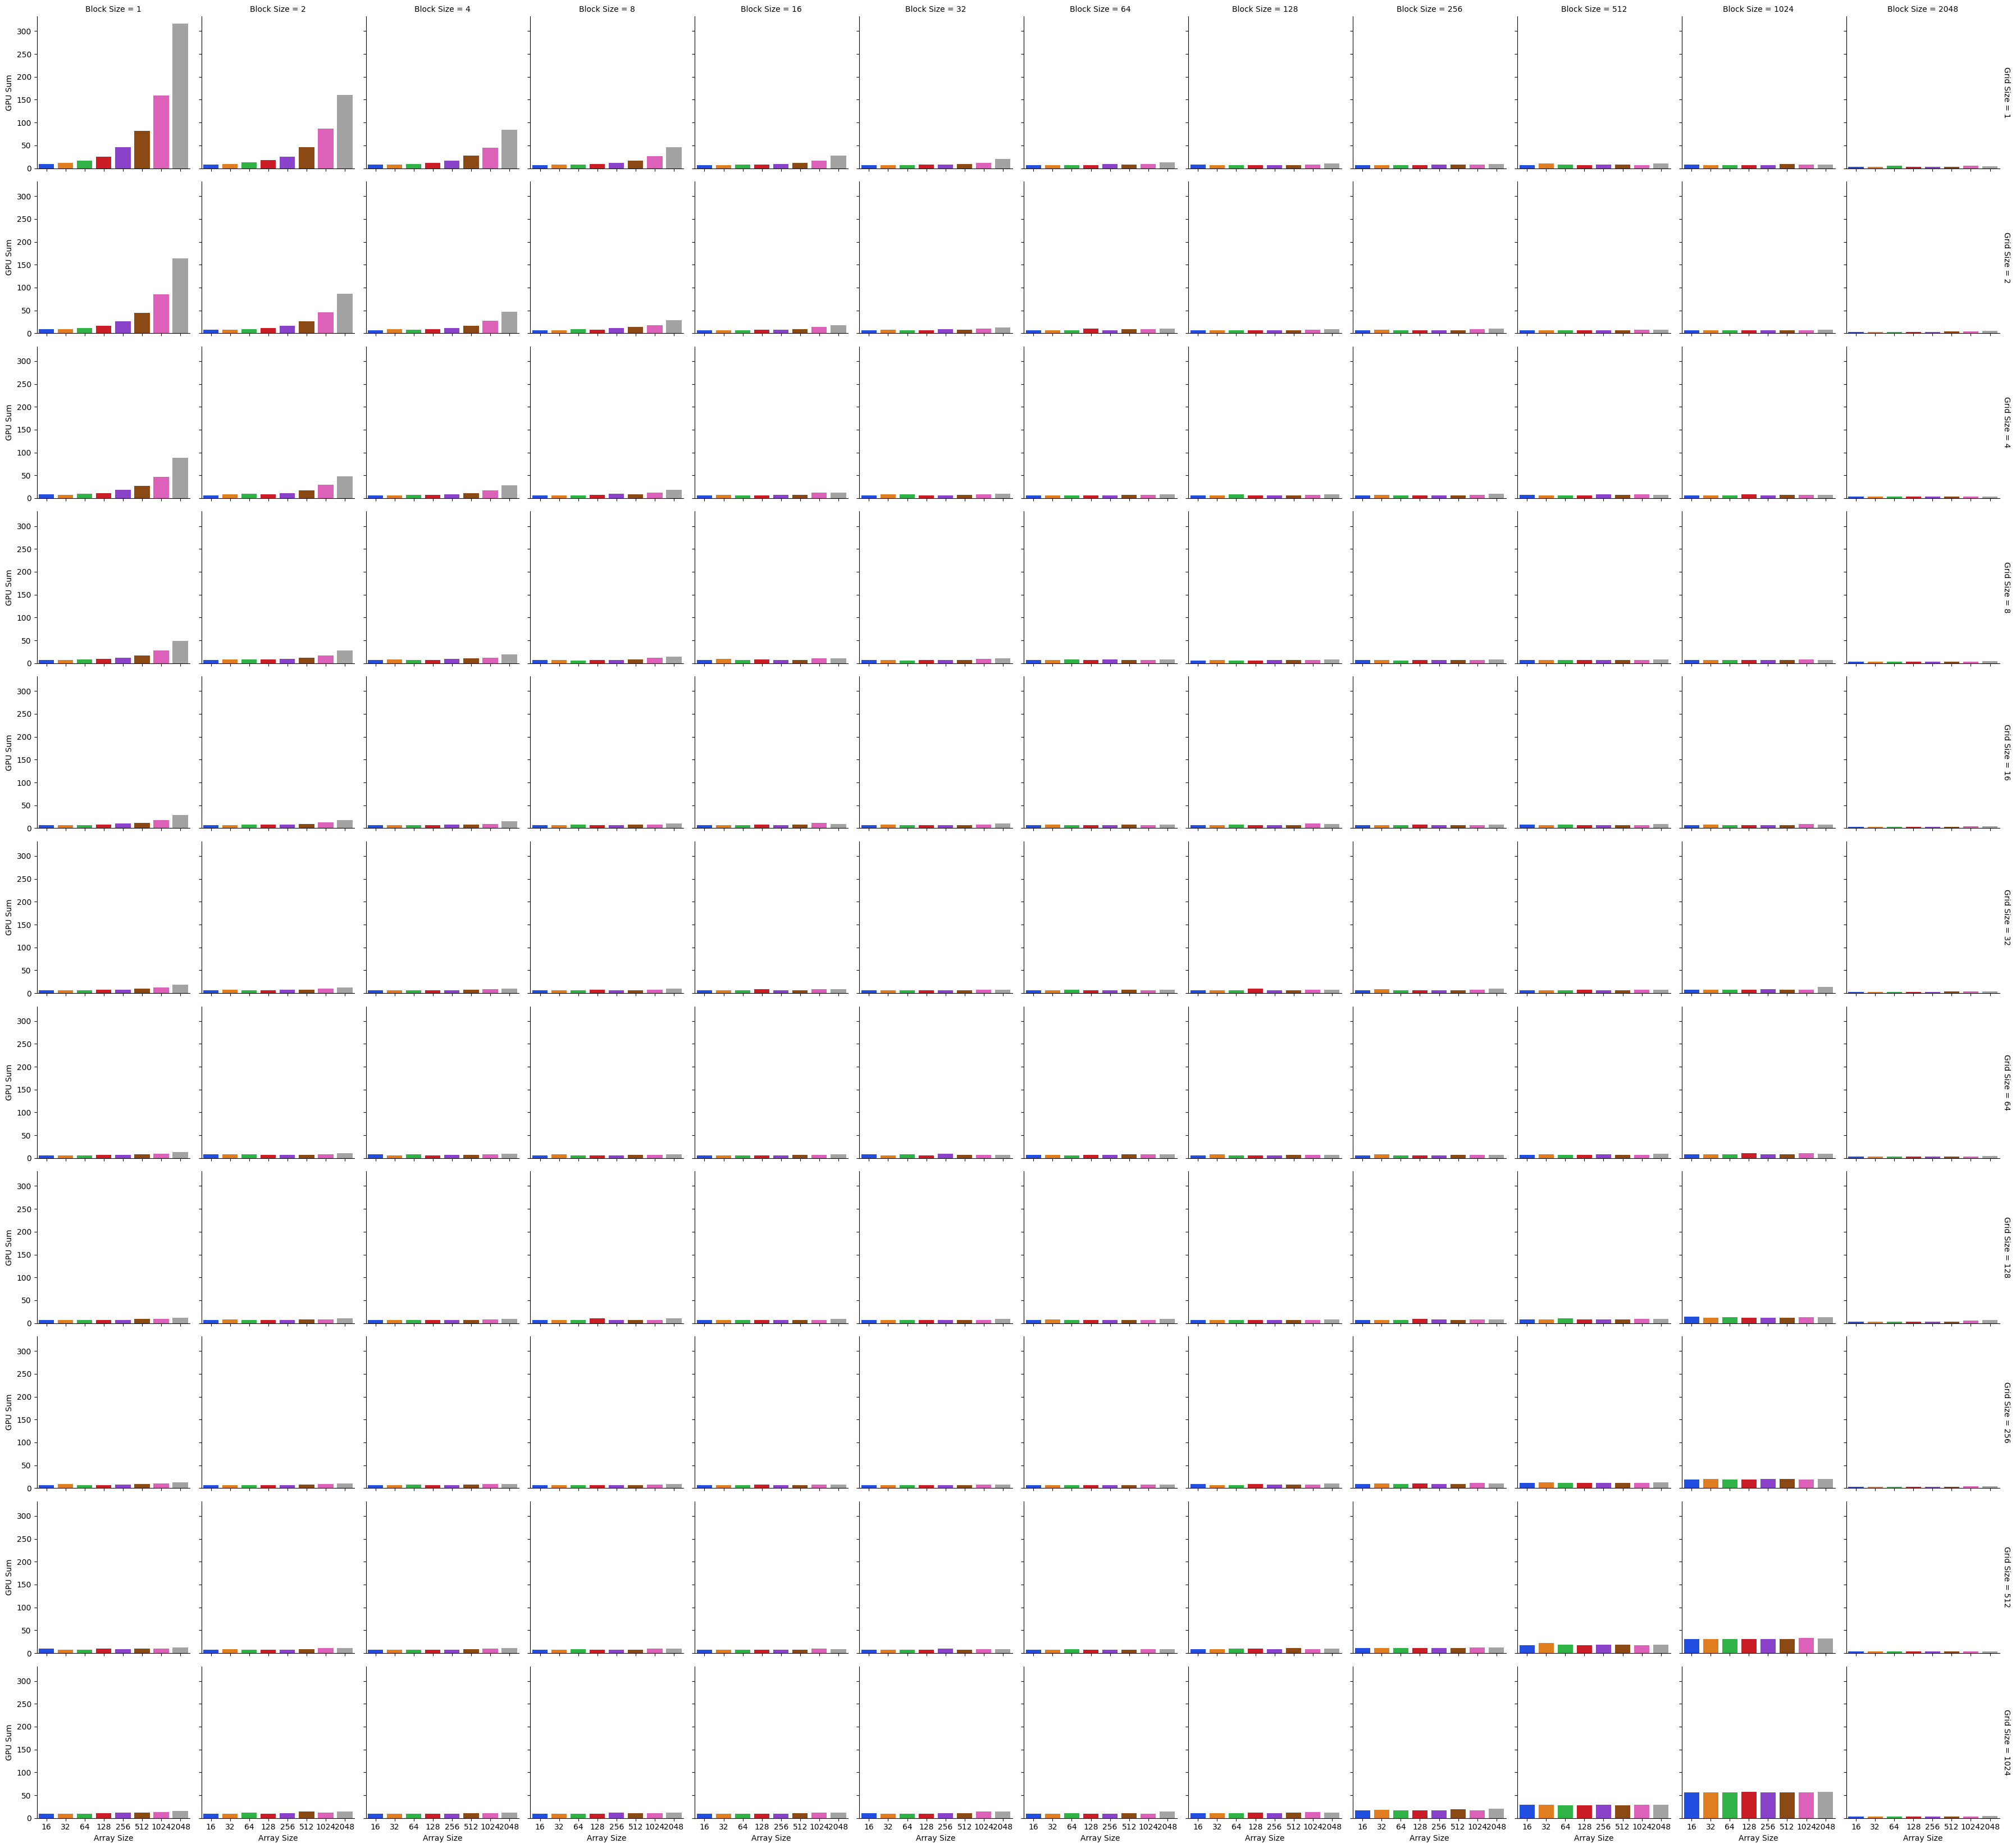

In [92]:
g = sns.FacetGrid(mean_data, row="Grid Size", col="Block Size", margin_titles=True)
order = mean_data["Array Size"].value_counts().index
g.map_dataframe(
    sns.barplot,
    x="Array Size",
    y="GPU Sum",
    order=order,
    hue="Array Size",
    palette="bright",
)

plt.tight_layout()
plt.show()
g.savefig(f"{output_filename}_full_comparison.png")

## 3D Bar plot

Here we are testing a 3D bar plot to visualize the data.

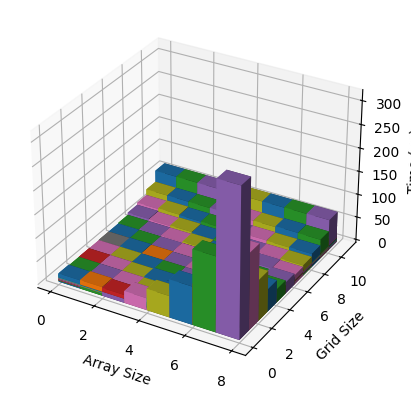

In [93]:
mean_data["Array Size"] = mean_data["Array Size"].astype(float)
mean_data["Grid Size"] = mean_data["Grid Size"].astype(float)
mean_data["Block Size"] = mean_data["Block Size"].astype(float)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

for i, array_size in enumerate(mean_data["Array Size"].unique()):
    for j, grid_size in enumerate(mean_data["Grid Size"].unique()):
        for k, block_size in enumerate(mean_data["Block Size"].unique()):
            # Filter the DataFrame for the current combination of array_size, grid_size, and block_size
            subset = mean_data[
                (mean_data["Array Size"] == array_size)
                & (mean_data["Grid Size"] == grid_size)
                & (mean_data["Block Size"] == block_size)
            ]
            if not subset.empty:
                ax.bar3d(i, j, k, 1, 1, subset["GPU Sum"].values[0], shade=True)

ax.set_xlabel("Array Size")
ax.set_ylabel("Grid Size")
ax.set_zlabel("Time (us)")

plt.show()
fig.savefig(f"{output_filename}_3D_bar_plot.png")